# Import supporting package

In [1]:
import copy
import glob
from datetime import datetime

# The package for data structure
import xarray as xr
import pandas as pd
import numpy as np

# The packages for working with uncertainties
from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

# The package for plotting
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 # Set the global font size

# -------------- The modules written by us --------------

# The packages for read data
from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file

# The packages for data analysis
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

# Add errorbar plot to xarray package
from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=8, threads_per_worker=16, processes=True, memory_limit='20GB')
client

<Client: 'tcp://127.0.0.1:57821' processes=8 threads=128, memory=149.01 GiB>

## Set global path for experiment

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}


In [4]:
# img_dir = 'C:/Users/control/DyLab/Experiments/DyBEC/'
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling"
folderPath = img_dir + SequenceName + "/" + '2023/07/03'# get_date()

# Load data

## along x-axis

In [5]:
compX = xr.open_zarr("./compX.zarr")
compY = xr.open_zarr("./compY.zarr")
compZ = xr.open_zarr("./compZ.zarr")

In [6]:
B = np.sqrt((compX['als_final_current'] * 9.52 -0.164)**2 + (0.435**2 - 0.164**2))
compX['als_final_current'] = B
compX['als_final_current'] = B

In [7]:
B = np.sqrt((compY['als_final_current'] * 10.3 + 0.202)**2 + (0.440**2 - 0.202**2))
compY['als_final_current'] = B
compY['als_final_current'] = B

In [8]:
B = np.sqrt((compZ['als_final_current'] * 10.6021 + 0.3254)**2 + (0.4333**2 - 0.3254**2))
compZ['als_final_current'] = B
compZ['als_final_current'] = B

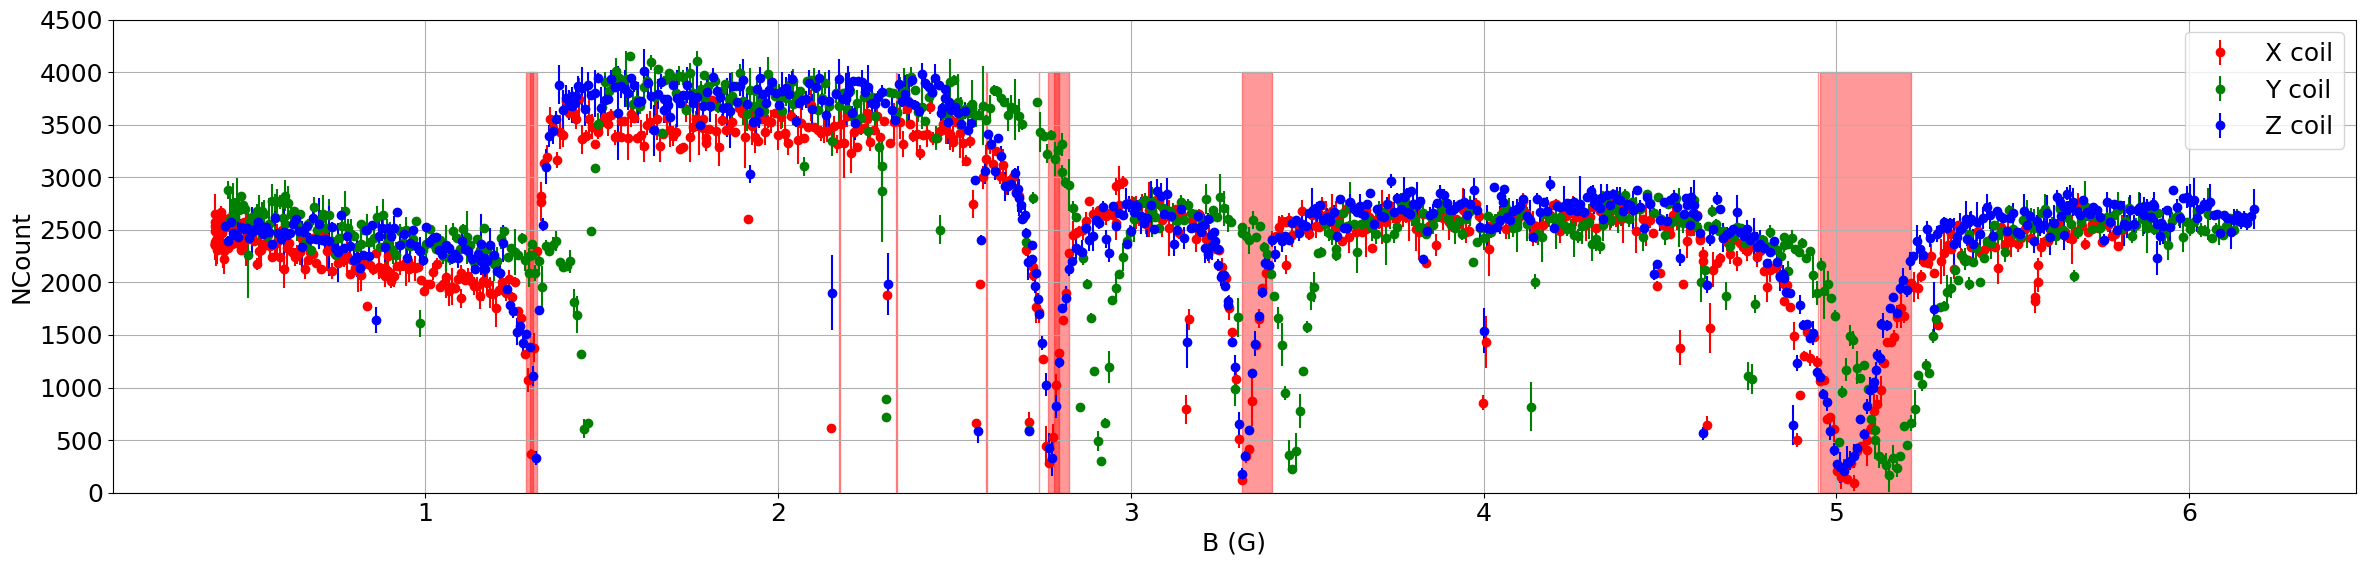

In [9]:
import matplotlib.patches as patches

B0 = [1.2950, 1.3060, 2.1740, 2.3360, 2.5910, 2.7400, 2.8030, 2.7800, 3.3570, 4.9490, 5.0830]# , 7.1720, 7.2040, 7.1340]
B0_width = [0.0090, 0.0100, 0.0005, 0.0005, 0.0010, 0.0005, 0.0210, 0.0150, 0.0430, 0.0005, 0.1300]# , 0.0240, 0.0005, 0.0360]

fig = plt.figure(figsize=(24,6))
ax = fig.gca()
compX['OD'].plot.errorbar(ax=ax, yerr = compX['std'], fmt='or', label='X coil')
compY['OD'].plot.errorbar(ax=ax, yerr = compY['std'], fmt='og', label='Y coil')
compZ['OD'].plot.errorbar(ax=ax, yerr = compZ['std'], fmt='ob', label='Z coil')

for i in range(len(B0)):
    rect = patches.Rectangle((B0[i] - B0_width[i], 000), B0_width[i]*2, 4000, linewidth=1, edgecolor='r', facecolor='r', alpha=0.4)
    ax.add_patch(rect)

plt.legend()

plt.ylim([0, 4500])
plt.ylabel('NCount')
plt.xlabel('B (G)')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [24]:
# CompX
f = [0.54427 , 0.36366 , 0.30532, 0.29893 , 0.28320 , 0.25629 , 0.23891 , 0.147] 
df = [0.00046 , 0.00010 ,0.00013 , 0.00011 , 0.00004 , 0.00407 , 0.01, 0.01]
B = [5.0830, 3.3570, (2.8030 + 2.7800)/2, 2.7400, 2.5910, 2.3360, 2.1740, (1.2950 + 1.3060)/2]

f = unp.uarray(f, df)
f = unp.sqrt((f * 9.52 -0.164)**2 + (0.435**2 - 0.164**2))

unp.nominal_values(f)

CompX_peak_val = xr.DataArray(
    data=unp.nominal_values(f),
    dims='x',
    coords=dict(x=np.arange(7, -1, -1))
)

CompX_peak_std = xr.DataArray(
    data=unp.std_devs(f),
    dims='x',
    coords=dict(x=np.arange(7, -1, -1))
)

In [25]:
# CompY
f = [0.47870 , 0.31417 ,0.26099 ,0.25506 ,0.24090 ,0.21583 ,0.20091 ,0.1165] 
df = [0.00036 ,0.00010 ,0.00017 ,0.00041 ,0.00003 ,0.00015 ,0.00726 ,0.001]
B = [(1.2950 + 1.3060)/2, 2.1740, 2.3360, 2.5910, 2.7400, (2.8030 + 2.7800)/2, 3.3570, 5.0830]

f = unp.uarray(f, df)
f = unp.sqrt((f * 10.3 + 0.202)**2 + (0.440**2 - 0.202**2))

unp.nominal_values(f)

CompY_peak_val = xr.DataArray(
    data=unp.nominal_values(f),
    dims='x',
    coords=dict(x=np.arange(7, -1, -1))
)

CompY_peak_std = xr.DataArray(
    data=unp.std_devs(f),
    dims='x',
    coords=dict(x=np.arange(7, -1, -1))
)

In [34]:
# CompZ
f = [0.44224, 0.28128, 0.22367, 0.22962, 0.21004, 0.18586, 0.17055, 0.0903] 
df = [0.00038, 0.00016, 0.01, 0.00013, 0.00012, 0.00021, 0.00175, 0]
B = [(1.2950 + 1.3060)/2, 2.1740, 2.3360, 2.5910, 2.7400, (2.8030 + 2.7800)/2, 3.3570, 5.0830]

f = unp.uarray(f, df)
f = unp.sqrt((f * 10.6021 + 0.3254)**2 + (0.4333**2 - 0.3254**2))

unp.nominal_values(f)

CompZ_peak_val = xr.DataArray(
    data=unp.nominal_values(f),
    dims='x',
    coords=dict(x=np.arange(7, -1, -1))
)

CompZ_peak_std = xr.DataArray(
    data=unp.std_devs(f),
    dims='x',
    coords=dict(x=np.arange(7, -1, -1))
)

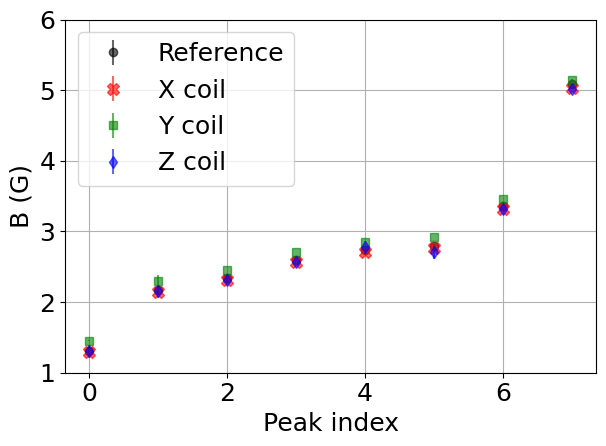

In [52]:
B = [(1.2950 + 1.3060)/2, 2.1740, 2.3360, 2.5910, 2.7400, (2.8030 + 2.7800)/2, 3.3570, 5.0830]
B_width = [(0.0090 + 0.0100)/2, 0.0005, 0.0005, 0.0010, 0.0005, (0.0210 + 0.0150)/2, 0.0430, 0.1300]# , 0.0240, 0.0005, 0.0360]

Ref_peak_val = xr.DataArray(
    data=unp.nominal_values(B),
    dims='x',
    coords=dict(x=np.arange(8))
)

Ref_peak_std = xr.DataArray(
    data=unp.std_devs(B_width),
    dims='x',
    coords=dict(x=np.arange(8))
)

fig = plt.figure()
ax = fig.gca()

Ref_peak_val.plot.errorbar(ax=ax, yerr=Ref_peak_std, fmt='ok', label='Reference', markersize=6, alpha=0.6)
CompX_peak_val.plot.errorbar(ax=ax, yerr=CompX_peak_std, fmt='Xr', label='X coil', markersize=8, alpha=0.6)
CompY_peak_val.plot.errorbar(ax=ax, yerr=CompY_peak_std, fmt='sg', label='Y coil', markersize=6, alpha=0.6)
CompZ_peak_val.plot.errorbar(ax=ax, yerr=CompZ_peak_std, fmt='db', label='Z coil', markersize=6, alpha=0.6)

plt.legend()

plt.ylim([1, 6])
plt.ylabel('B (G)')
plt.xlabel('Peak index')
plt.tight_layout()
plt.grid(visible=1)

plt.show()

In [61]:
np.round(CompY_peak_val.to_numpy(), 4)

array([5.1475, 3.4601, 2.9165, 2.856 , 2.7116, 2.4564, 2.3048, 1.4554])

In [62]:
np.round(CompY_peak_std.to_numpy(), 4)

array([0.0037, 0.001 , 0.0017, 0.0042, 0.0003, 0.0015, 0.0737, 0.0099])